In [1]:
import os
import pandas as pd

data_dir = "../assets/aclImdb"  

# Initialize lists to store reviews and labels
reviews = []
labels = []

# Load positive reviews
pos_dir = os.path.join(data_dir, "train", "pos")
for file in os.listdir(pos_dir):
    with open(os.path.join(pos_dir, file), "r", encoding="utf-8") as f:
        reviews.append(f.read())
    labels.append(1)  # 1 for positive

# Load negative reviews
neg_dir = os.path.join(data_dir, "train", "neg")
for file in os.listdir(neg_dir):
    with open(os.path.join(neg_dir, file), "r", encoding="utf-8") as f:
        reviews.append(f.read())
    labels.append(0)  # 0 for negative

# Create a DataFrame
df = pd.DataFrame({"Review": reviews, "Sentiment": labels})

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows
print(df.head())

                                              Review  Sentiment
0  Great little thriller. I was expecting some ty...          1
1  Nothing could have saved this movie, not even ...          0
2  This was a good movie. It wasn't your typical ...          1
3  From the pen of Richard Condon (The Manchurian...          0
4  I suppose that today this film has relevance b...          0


In [2]:
# Check the distribution of sentiments
print(df["Sentiment"].value_counts())

# View a sample review
print(df["Review"].iloc[0])
print(f"Sentiment: {'Positive' if df['Sentiment'].iloc[0] else 'Negative'}")

Sentiment
1    12500
0    12500
Name: count, dtype: int64
Great little thriller. I was expecting some type of silly horror movie but what I got was tight short thriller that waste none of our time. Mostof these movies we have to get into the back characters stories so we will either feel sympathy for them or hatred when people start getting killed. o such foolishness here. Yes you see a few characters but they really only interact with the principals. Such as the husband wife at the motel whose room was canceled. We saw them so we could just how efficient the Lisa character was and how inefficient the new Hotel clerk was. We see the little girl simply because she will have a very small but important role later in the movie when all heck breaks loose. THe Flight Atrendants because we need on in particular to move the plot ahead. The bad guy in particular needs her in the beginning of the flight. The rude guy in the airport was important to the movie too. The only 2 characters that were 

## Preprocessing

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# Tokenize the text
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df["Review"])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df["Review"])

# Pad sequences to ensure uniform length
maxlen = 500
data = pad_sequences(sequences, maxlen=maxlen)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, df["Sentiment"], test_size=0.2, random_state=42)

## Train the model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/5


/Users/robbieardison/anaconda3/envs/tf-pro/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 115s 457ms/step - accuracy: 0.6390 - loss: 0.6165 - val_accuracy: 0.8365 - val_loss: 0.3811
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 110s 441ms/step - accuracy: 0.8790 - loss: 0.2997 - val_accuracy: 0.8670 - val_loss: 0.3539
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 112s 450ms/step - accuracy: 0.9218 - loss: 0.2151 - val_accuracy: 0.8568 - val_loss: 0.3499
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 110s 441ms/step - accuracy: 0.9434 - loss: 0.1620 - val_accuracy: 0.8680 - val_loss: 0.3896
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 111s 445ms/step - accuracy: 0.9528 - loss: 0.1403 - val_accuracy: 0.8378 - val_loss: 0.4078
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.8425 - loss: 0.4023
Test Accuracy: 0.8392


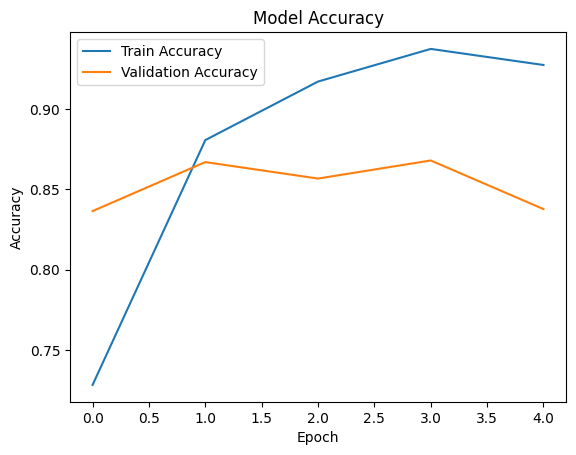

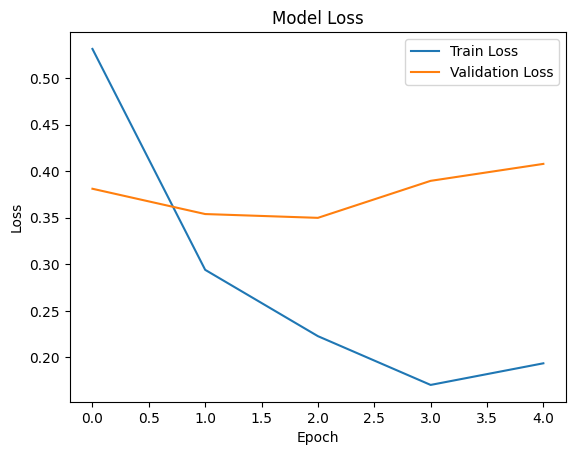

In [7]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Since it is overfitting. Let's tune the model.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))
model.add(LSTM(128, kernel_regularizer=l2(0.01)))  # Add L2 regularization
model.add(Dropout(0.5))  # Add dropout
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

/Users/robbieardison/anaconda3/envs/tf-pro/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 118s 469ms/step - accuracy: 0.6335 - loss: 1.2805 - val_accuracy: 0.8380 - val_loss: 0.4009
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 114s 455ms/step - accuracy: 0.8508 - loss: 0.4024 - val_accuracy: 0.8500 - val_loss: 0.3638
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 436ms/step - accuracy: 0.9110 - loss: 0.2590 - val_accuracy: 0.8355 - val_loss: 0.3865
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 435ms/step - accuracy: 0.9318 - loss: 0.2153 - val_accuracy: 0.8580 - val_loss: 0.3511
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 111s 443ms/step - accuracy: 0.9463 - loss: 0.1828 - val_accuracy: 0.8618 - val_loss: 0.3511
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 113s 451ms/step - accuracy: 0.9599 - loss: 0.1360 - val_accuracy: 0.8500 - val_loss: 0.3763
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 114s 455ms/step - accuracy: 0.9644 - loss: 0.1272 - val_accuracy: 0.8640 - val_loss: 0.4445


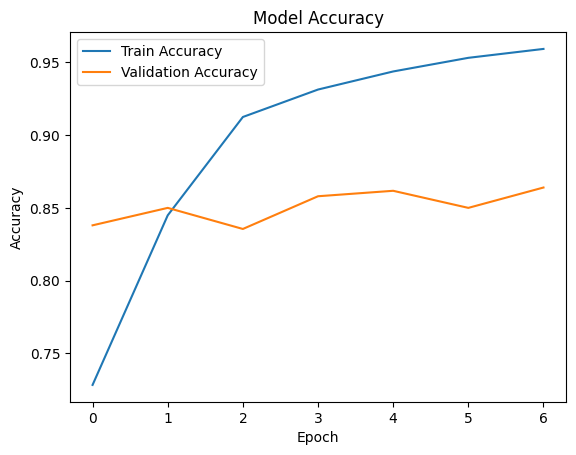

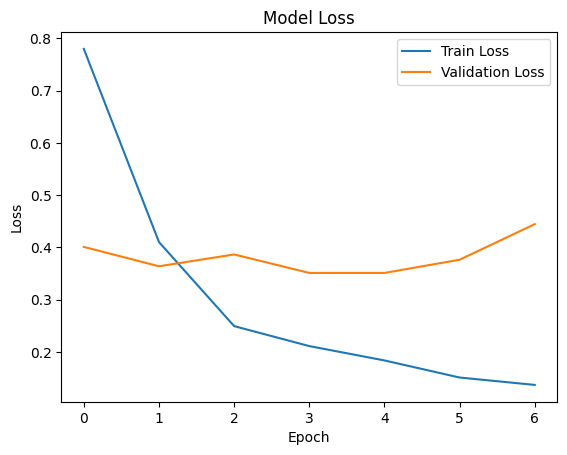

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()